In [1]:
import geemap
from geemap import colormaps
from geemap import foliumap
import ee
import sys
sys.path.append('C:/Users/wb514197/Repos/GEE_Zonal/src')
from gee_tools import Catalog, ZonalStats
from gee_helpers import get_zonal_res
import pandas as pd
import os
import glob
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from geemap.conversion import *
import geopandas as gpd

eemont not available
Google Drive tools are not available


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.path.realpath("..")

'C:\\Users\\wb514197\\Repos\\Lights_Sandbox'

In [4]:
ee.Initialize()

In [5]:
# pac_dir = os.path.join(os.path.expanduser("~"), 'data', 'pacific')
pac_dir = 'X:/data/pacific'
png_dir = os.path.join(pac_dir, "PNG")
out_dir = os.path.join(png_dir, 'output')
min_dir = os.path.join(png_dir, 'mining')

In [6]:
# pac_path = 'C:/Users/wb514197/WBG/Pacific Observatory - WB Group - Geospatial and Big Data/Data/Admin Boundaries'
pac_path = r'C:\Users\wb514197\WBG\EEAPV Files - Geospatial and Big Data\Data\Admin Boundaries'
pac_adm0 = gpd.read_file(os.path.join(pac_path, "Adm0_Pacific.shp"))

In [7]:
pac_adm0.columns

Index(['OBJECTID', 'ISO_A2', 'WB_ADM0_CO', 'WB_ADM0_NA', 'Shape_Leng',
       'Shape_Area', 'ISO3', 'UN_m49', 'Region', 'incomeG', 'lendingC',
       'FID_100', 'SPC', 'geometry'],
      dtype='object')

In [8]:
pac_adm0.WB_ADM0_NA.unique()

array(['American Samoa (U.S.)', 'Baker Island (U.S.)',
       'Cook Islands (N.Z.)', 'Fiji', 'French Polynesia (Fr.)',
       'Guam (U.S.)', 'Howland Island (U.S.)', 'Jarvis Island (U.S.)',
       'Johnston Atoll (U.S.)', 'Kingman Reef (U.S.)', 'Kiribati',
       'Marshall Islands', 'Federated States of Micronesia',
       'Midway Island (U.S.)', 'Nauru', 'New Caledonia (Fr.)',
       'Niue (N.Z.)', 'Norfolk Island (Aus.)',
       'Northern Mariana Islands (U.S.)', 'Palau', 'Palmyra Atoll (U.S.)',
       'Papua New Guinea', 'Pitcairn Islands (U.K.)', 'Samoa',
       'Solomon Islands', 'Tokelau (N.Z.)', 'Tonga', 'Tuvalu', 'Vanuatu',
       'Wake Island (U.S.)', 'Wallis and Futuna (Fr.)'], dtype=object)

In [9]:
sel = [
    'Federated States of Micronesia', 
    'Fiji',
    'Kiribati',
    'Marshall Islands',
    'Nauru',
    'Palau',
    'Papua New Guinea',
    'Samoa',
    'Solomon Islands',
    'Tonga',
    'Tuvalu',
    'Vanuatu'
]

In [10]:
pac = pac_adm0.loc[pac_adm0.WB_ADM0_NA.isin(sel)].copy()

In [12]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('cf_cvg') #.filterDate('2019-01-01', "2021-12-31")

In [19]:
def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())

In [13]:
aoi = geopandas_to_ee(pac)

Check cloud issues

In [22]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('cf_cvg')# .filterDate('2019-01-01', "2021-12-31")
# one = cf_cvg.first().clip(aoi)
# one = one.mask(one)

In [23]:
def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())

In [24]:
coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

In [25]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
res = res.getInfo()

In [26]:
df_gt0 = get_zonal_res(res)

In [27]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
res = res.getInfo()

In [28]:
df_gte0 = get_zonal_res(res)

In [29]:
df_gt0.columns

Index(['20140101_cf_cvg', '20140201_cf_cvg', '20140301_cf_cvg',
       '20140401_cf_cvg', '20140501_cf_cvg', '20140601_cf_cvg',
       '20140701_cf_cvg', '20140801_cf_cvg', '20140901_cf_cvg',
       '20141001_cf_cvg',
       ...
       'OBJECTID', 'Region', 'SPC', 'Shape_Area', 'Shape_Leng', 'UN_m49',
       'WB_ADM0_CO', 'WB_ADM0_NA', 'incomeG', 'lendingC'],
      dtype='object', length=114)

In [66]:
# pac_df = pac.drop(columns='geometry')
# pac_df.columns

In [31]:
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
# df_gt0.loc[:, pac_df.columns]
# import numpy as np
# list(np.invert(filt))

In [32]:
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))

In [33]:
df_pct.columns

Index(['FID_100', 'ISO3', 'ISO_A2', 'OBJECTID', 'Region', 'SPC', 'Shape_Area',
       'Shape_Leng', 'UN_m49', 'WB_ADM0_CO',
       ...
       '20210801_cf_cvg', '20210901_cf_cvg', '20211001_cf_cvg',
       '20211101_cf_cvg', '20211201_cf_cvg', '20220101_cf_cvg',
       '20220201_cf_cvg', '20220301_cf_cvg', '20220401_cf_cvg',
       '20220501_cf_cvg'],
      dtype='object', length=114)

In [34]:
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col

In [35]:
df_pct.rename(rename_func, axis=1, inplace=True)

In [36]:
df_pct.columns

Index(['FID_100', 'ISO3', 'ISO_A2', 'OBJECTID', 'Region', 'SPC', 'Shape_Area',
       'Shape_Leng', 'UN_m49', 'WB_ADM0_CO',
       ...
       'pct__20210801', 'pct__20210901', 'pct__20211001', 'pct__20211101',
       'pct__20211201', 'pct__20220101', 'pct__20220201', 'pct__20220301',
       'pct__20220401', 'pct__20220501'],
      dtype='object', length=114)

In [37]:
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'WB_ADM0_NA',
    j = 'date',
    sep = "__"
)

In [38]:
df_pct_re.reset_index(inplace=True)

In [39]:
df_pct_re.loc[:,"date"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [40]:
df_pct_re.to_csv(os.path.join(out_dir, "adm0_pct_cloud.csv"))

In [130]:
# df_pct_re.head()

In [131]:
sns.set()

In [140]:
sns.reset_defaults()

<AxesSubplot:xlabel='date', ylabel='pct'>

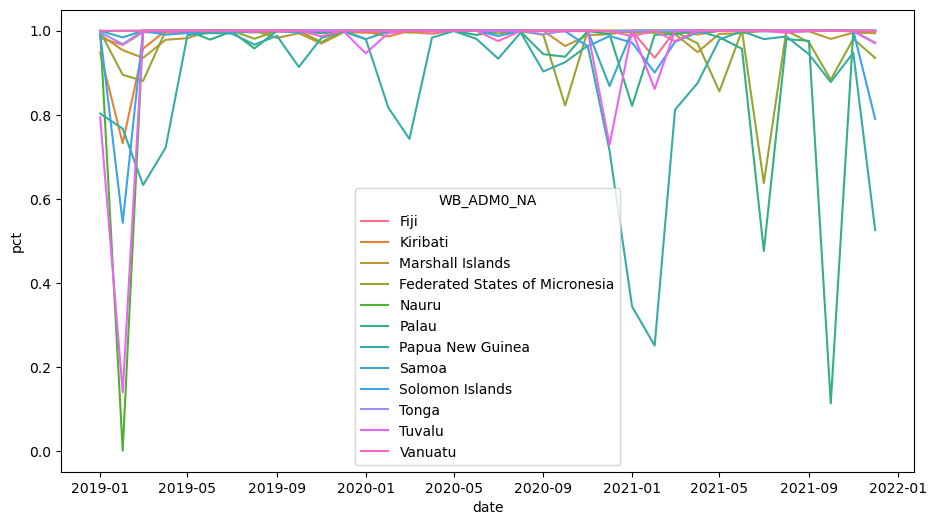

In [141]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_pct_re, x="date", y="pct", hue='WB_ADM0_NA')
# ax.set(ylim=(0, 36000))

In [142]:
out_dir

'X:/data/pacific\\PNG\\output'

Run monthly smoothen VIIRS radiance

In [18]:
def smoothenViirs(collection, window_size):
    
    def prepareImage(img):
        
        # mask values less or equal than 0
        img_masked = img.mask(img)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smooter function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [19]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad')
#     .filterDate('2017-01-01', "2021-05-31")

In [20]:
viirs_interpolated = smoothenViirs(viirs, 3)

In [21]:
# stats = ['sum', 'median', 'max', 'stdDev', 'p25', 'p75', 'p95']
# var_name = 'rad'
# stubs = [var_name + "_" + stat for stat in stats]
# stubs = ["_".join([var, stat]) for stat in stats]

In [22]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    output_name = '',
    scale = 500,
#     start_year = 2019,
#     end_year = 2022,
    frequency = 'annual',
    temporal_stat = 'mean',
    output_dir = '',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
res = res.getInfo()

In [24]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    output_name = '',
    scale = 500,
#     start_year = 2019,
#     end_year = 2022,
    frequency = 'original',
    output_dir = '',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
res = res.getInfo()

In [24]:
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
ids = [f['id'] for f in feats] # NEED THIS IF DOING MULTIPLE AOIS AT ONCE
keys = [list(f['properties'].keys()) for f in feats]
values = [list(f['properties'].values()) for f in feats]
df = pd.DataFrame(index=ids, columns=cols, data=values)

In [25]:
# df.loc["83", "Name"] = "Tolukuma Mine Mindat"

In [26]:
df.head()

,2014_avg_rad_mean,2015_avg_rad_mean,2016_avg_rad_mean,2017_avg_rad_mean,2018_avg_rad_mean,2019_avg_rad_mean,2020_avg_rad_mean,2021_avg_rad_mean,ADM1_EN,ADM1_PCODE,...,empty,gas,group,index,lat,location,lon,province,source,type
0,36.121041,31.198593,28.893325,30.612451,28.993219,12.790287,20.990171,19.196498,None,None,...,None,NaN,None,0,NaN,None,NaN,None,Google Maps KML,None
1,808.485785,924.367714,980.258015,1237.117738,1202.452950,921.936661,1328.275424,1311.052971,None,None,...,None,NaN,None,1,NaN,None,NaN,None,Google Maps KML,None
2,740.674818,698.303431,715.512711,936.991829,967.020499,1013.498146,1020.456765,1044.253300,None,None,...,None,NaN,None,2,NaN,None,NaN,None,Google Maps KML,None
3,630.687320,757.560877,624.744350,695.829171,583.235514,580.956318,1044.024043,929.565765,None,None,...,None,NaN,None,3,NaN,None,NaN,None,Google Maps KML,None
4,8.912061,21.701521,17.954618,28.124755,46.908929,17.623261,26.076832,32.416909,None,None,...,None,NaN,None,4,NaN,None,NaN,None,Google Maps KML,None


In [29]:
def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df.rename(rename_func, axis=1, inplace=True)
df_re = pd.wide_to_long(
    df,
    stubnames = ['rad'],
    i = 'Name',
    j = 'date',
    sep = "__"
)
df_re.reset_index(inplace=True)
df_re.loc[:,"date"] = pd.to_datetime(df_re.date, format="%Y%m%d")
# df_re = df_re.loc[(df_re.date>='2019-01-01') & (df_re.date<'2021-01-01')].copy()
# df_re = df_re.loc[df_re.city!="Gumine"]
# df_re = df_re.loc[df_re.city.isin(list(sel.city))]

In [31]:
df_re.loc[:, ['index', 'Name', 'source', 'gas', 'date', 'ADM3_PCODE', 'lon', 'lat', 'ADM3_EN', 'PopupInfo', 'province', 'location', 'ADM1_EN', 'ADM1_PCODE', 'ADM2_PCODE', 'ID', 'group', 'ADM2_EN', 'confirmed', 'rad']].to_csv(os.path.join(out_dir, "mines_all_ntl_monthly.csv")) # mines
# df_re.to_csv(os.path.join(out_dir, "mines_mask_ntl.csv")) 
# df_re.to_csv(os.path.join(out_dir, "mines_ntl.csv")) # mines
# df_re.to_csv(os.path.join(out_dir, "mindat_ntl.csv")) # mines

In [27]:
df.to_csv(os.path.join(out_dir, "mines_all_ntl_annual_v3.csv")) # mines

<AxesSubplot:xlabel='date', ylabel='rad'>

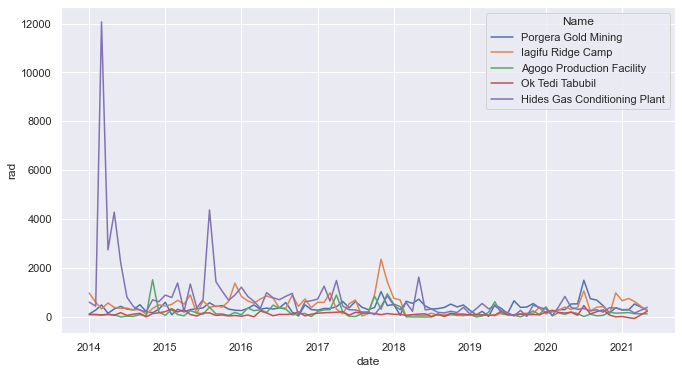

In [195]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re, x="date", y="rad", hue='Name')
# ax.set(ylim=(0, 36000))

<AxesSubplot:xlabel='date', ylabel='rad'>

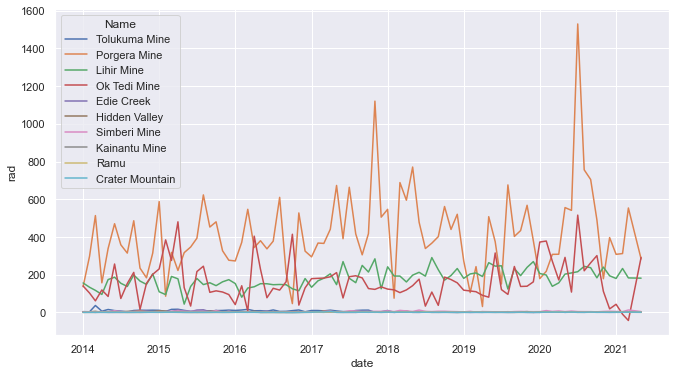

In [170]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re, x="date", y="rad", hue='Name')
# ax.set(ylim=(0, 36000))

<AxesSubplot:xlabel='date', ylabel='rad'>

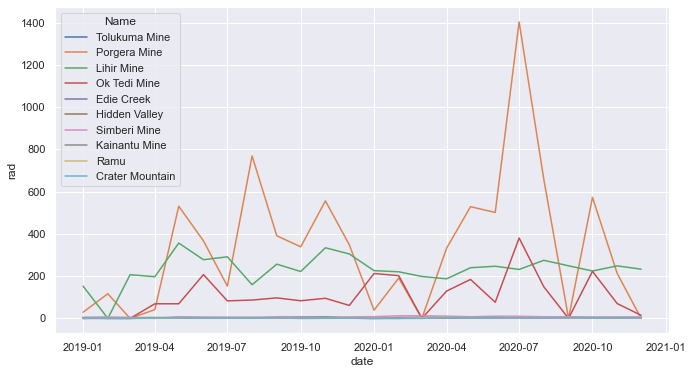

In [127]:
# not interpolated
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re, x="date", y="rad", hue='Name')
# ax.set(ylim=(0, 36000))

Run Annual NTL but from Harmonized

In [18]:
from glob import glob
import rasterio as rio
from rasterstats import zonal_stats
from affine import Affine

In [19]:
ntl_dir = 'P:/Data/GLOBAL/NighttimeLights'
harm_dir = os.path.join(ntl_dir, 'LI_HARMONIZED')

In [20]:
# files = os.listdir(harm_dir)
# files = glob(harm_dir+"/*")
files = glob(harm_dir+"/Harmonized*.tif")

In [21]:
files.sort()

In [22]:
# files[14:]

In [23]:
file = 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_2006_calDMSP.tif'

In [24]:
file[file.find("20"):file.find("20")+4]

'2006'

In [25]:
file.split("_")[-2]

'2006'

In [26]:
geom = png.geometry.iloc[0]

In [27]:
# window = features.geometry_window(cur_tif, [geometry])
# ul_y = window.col_off
# lr_x = window.row_off
# shifted_affine = Affine(t.a, t.b, t.c+ul_y*t.a, t.d, t.e, t.f+lr_x*t.e)

In [28]:
res = sites.copy()

In [29]:
# sites.head()

In [30]:
# for file in files:
#     year = file.split("_")[-2]
#     print(year)

In [31]:
for file in files: #[14:]:
#     year = file[file.find("20"):file.find("20")+4]
    year = file.split("_")[-2]
    src = rio.open(file)
    
    ul = src.index(*geom.bounds[0:2])
    lr = src.index(*geom.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    t = src.transform
    shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
    
    data = src.read(1, window=window)
#     data = data+2.5
#     data = np.log(data)
    
    zs = pd.DataFrame(zonal_stats(sites, data, affine=shifted_affine, stats='sum', nodata=-1.5)).rename(columns = {'sum': f'{year}'})
    res = res.join(zs)
    print(f"done with {year}")

done with 1992
done with 1993
done with 1994
done with 1995
done with 1996
done with 1997
done with 1998
done with 1999
done with 2000
done with 2001
done with 2002
done with 2003
done with 2004
done with 2005
done with 2006
done with 2007
done with 2008
done with 2009
done with 2010
done with 2011
done with 2012
done with 2013
done with 2014
done with 2015
done with 2016
done with 2017
done with 2018


In [32]:
res.columns

Index(['index', 'Name', 'SymbolID', 'PopupInfo', 'confirmed', 'geometry',
       'source', 'lat', 'lon', 'bool', 'ID', 'code', 'empty', 'type', 'group',
       'location', 'province', 'country', 'ADM3_EN', 'ADM3_PCODE', 'ADM2_EN',
       'ADM2_PCODE', 'ADM1_EN', 'ADM1_PCODE', 'gas', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [34]:
res.loc[:, res.columns!='geometry'].to_csv(os.path.join(out_dir, "mines_all_ntl_annual_v2.csv"), index=False) # mines

In [33]:
out_dir

'X:/data/pacific\\PNG\\output'

In [46]:
# # fig, ax = plt.subplots(figsize=(11, 6))
# sns.relplot(
#     data=df_re, x="date", y="rad",
#     col="city", hue="city",
#     kind="line", col_wrap=3, sharey=False
# )

In [47]:
# g = sns.FacetGrid(df_re, col="city", col_wrap=3, sharey=True)
# g.map(sns.lineplot, "date", "rad")

In [48]:
sns.set()

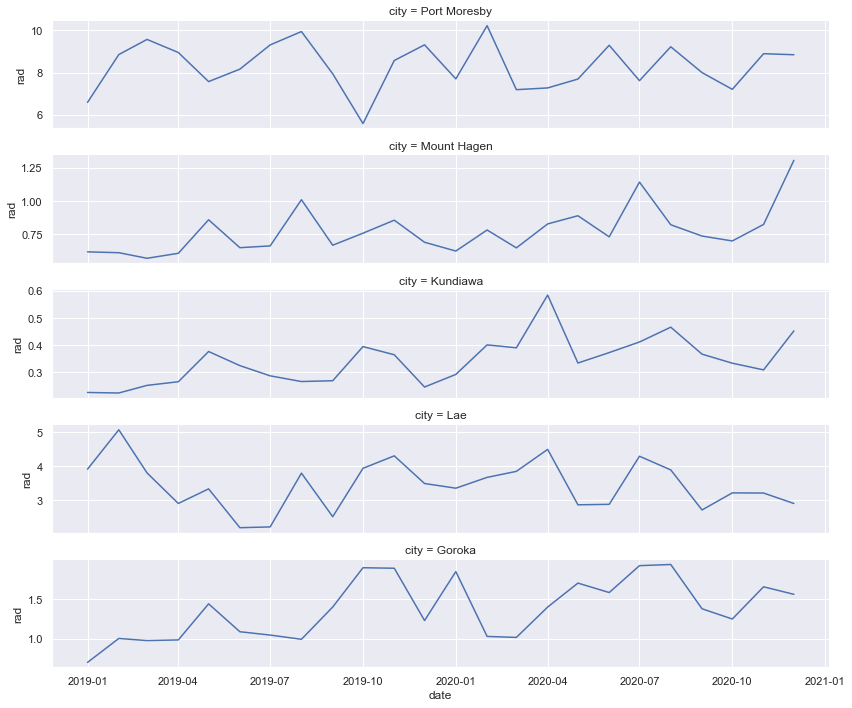

In [34]:
g = sns.FacetGrid(df_re, col="city", col_wrap=1, sharey=False, height=2, aspect=6)
g.map(sns.lineplot, "date", "rad")

In [60]:
from matplotlib.dates import DateFormatter

In [61]:
date_form = DateFormatter("%m-%d")

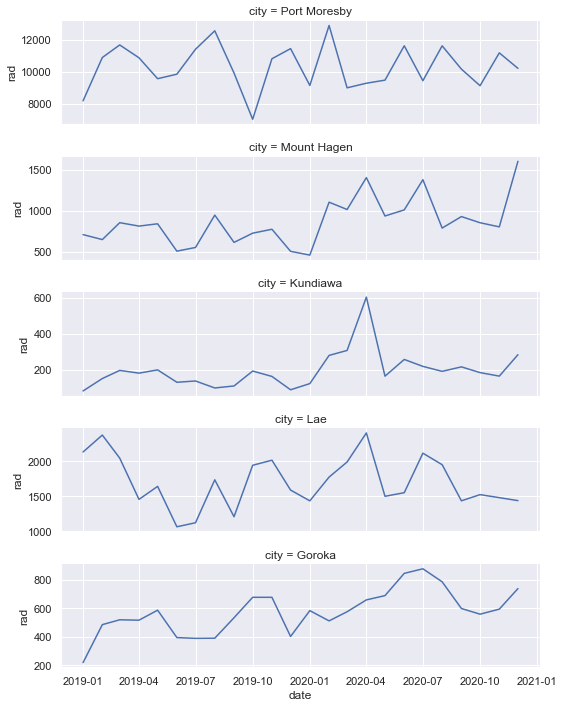

In [79]:
# fig, ax = plt.subplots(figsize=(12, 12))
g = sns.FacetGrid(df_re, col="city", col_wrap=1, sharey=False, height=2, aspect=4, sharex=True) #  height=4, aspect=3
g.map(sns.lineplot, "date", "rad")
# date_form = DateFormatter("%y,%m")
# g.axes[0].xaxis.set_major_formatter(date_form)

In [25]:
# g = sns.FacetGrid(df_re, col="city", col_wrap=1, sharey=False, height=2, aspect=6)
# g.map(sns.lineplot, "date", "rad")

Map cloud

In [60]:
vis_cloud2 = {
    'bands': ['cf_cvg'], 
    'palette': ['ffffff', 'cc0013'], 
    'min': 0, 
    'max': 1, 
    'opacity': 0.5
}

In [95]:
one = coverage_gt0.filterDate('2020-02-01', "2020-03-01")

In [105]:
# months = range(1, 13)

In [106]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [110]:
for i, m in enumerate(months):
    start = f"2020-{m}-01"
    try: 
        end = f"2020-{months[i+1]}-01"
    except:
        end = f"2021-01-01"
    print(start, end)
    one = coverage_gt0.filterDate(start, end)
    Map.addLayer(one, vis_cloud2, f'Cloud Free Coverage {m}')

2020-01-01 2020-02-01
2020-02-01 2020-03-01
2020-03-01 2020-04-01
2020-04-01 2020-05-01
2020-05-01 2020-06-01
2020-06-01 2020-07-01
2020-07-01 2020-08-01
2020-08-01 2020-09-01
2020-09-01 2020-10-01
2020-10-01 2020-11-01
2020-11-01 2020-12-01
2020-12-01 2021-01-01


In [96]:
Map.addLayer(one, vis_cloud2, 'Cloud Free Coverage')

In [97]:
Map

Map(bottom=272198.0, center=[-6.682339384819373, 146.99672698974612], controls=(WidgetControl(options=['positi…

In [101]:
# to remove
Map.remove_layer(Map.find_layer('Cloud Free Coverage'))

In [62]:
zs = ZonalStats(
    collection_id='NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features=aoi,
    statistic_type='sum',
    output_name='',
    scale=500,
    min_threshold=0,
    water_mask=False,
    start_year=2018,
    end_year=2022,
    frequency='original',
    temporal_stat=None,
    band='avg_rad',
    output_dir='',
)

In [46]:
zs = ZonalStats(
    collection_id='NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features=aoi,
    statistic_type='sum',
    output_name='',
    scale=500,
    start_year=2018,
    end_year=2022,
    frequency='original',
    output_dir='',
    ee_dataset=viirs_interpolated
)

In [63]:
res = zs.runZonalStats()

In [64]:
# geemap.ee_export_vector(res, "test_res.csv")

In [65]:
res = res.getInfo()

In [66]:
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
# res['columns'].pop('system:index')
# cols = list(res['columns'].keys())
ids = [f['id'] for f in feats]
values = [list(f['properties'].values()) for f in feats]

In [26]:
sns.set()

In [27]:
# df_re.loc[df_re.rad_sum==0, "rad_sum"] = pd.NA

In [58]:
df_re['rad_sum'].min()

21516.938221555545

In [76]:
df_re['rad_sum'].min()

808.391764694277

In [59]:
# df_re.loc[df_re.rad_sum.isna()]

[(0.0, 36000.0)]

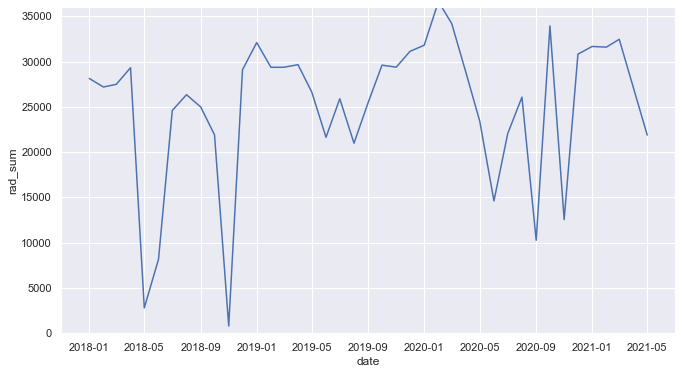

In [82]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re, x="date", y="rad_sum")
ax.set(ylim=(0, 36000))

[(0.0, 36000.0)]

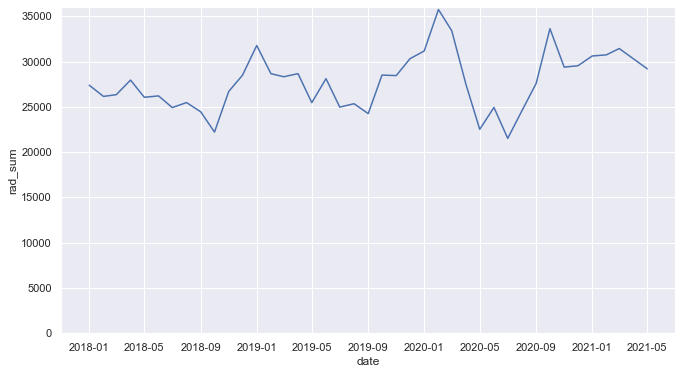

In [83]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re_int, x="date", y="rad_sum")
ax.set(ylim=(0, 36000))

In [45]:
# df_re['rad_sum'].astype('float')

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(data=df_re, x="date", y="rad_sum")

In [87]:
zs = ZonalStats(
    collection_id='NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features=aoi,
    statistic_type='mean',
    output_name='',
    scale=500,
    min_threshold=0,
    water_mask=False,
    start_year=2018,
    end_year=2022,
    frequency='original',
    temporal_stat=None,
    band='avg_rad',
    output_dir='',
)
res = zs.runZonalStats()
res = res.getInfo()
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
ids = [f['id'] for f in feats]
values = [list(f['properties'].values()) for f in feats]
df = pd.DataFrame(index=ids, columns=cols, data=values)
def rename_func(col):
    p = col.split("_")
    new_name = "rad_mean"+"__"+p[0]
    return new_name
df.rename(rename_func, axis=1, inplace=True)
df.reset_index(inplace=True)
df_re2 = pd.wide_to_long(
    df,
    stubnames = ['rad_mean'],
    i = 'index',
    j = 'date',
    sep = "__"
)
df_re2.reset_index(inplace=True)
df_re2.loc[:,"date"] = pd.to_datetime(df_re.date, format="%Y%m%d")

<AxesSubplot:xlabel='date', ylabel='rad_mean'>

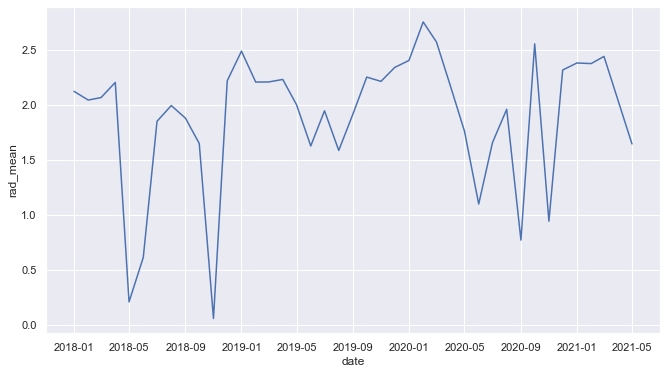

In [91]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re2, x="date", y="rad_mean")

In [41]:
viirs_col_raw = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', "2021-06-01")

In [42]:
viirs_col = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', "2021-06-01")

In [43]:
def prepareImage(img):
    img_clip = img.clip(aoi)
    img_masked = img_clip.mask(img_clip)
    return img_masked

In [44]:
viirs_col_clip_raw = viirs_col_raw.map(prepareImage)

In [45]:
viirs_col_clip = viirs_col.map(prepareImage)

In [11]:
# def ymList_ee(self):
#     '''
#     Create list of year/month pairs from a given dataset using EE
#     '''
#     def iter_func(image, newlist):
#         date = image.date().format("YYYY-MM")
#         return newlist.append(date)
#     ymd = self.iterate(iter_func, [])
#     return ymd

In [46]:
def ymList_ee(self):
    '''
    Create list of year/month pairs from a given dataset using EE
    '''
    def iter_func(image, newlist):
        date = ee.String(image.date().format("YYYY-MM"))
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = self.iterate(iter_func, ee.List([]))
    return ee.List(ymd).distinct()

In [47]:
dates = ymList_ee(viirs_col_clip)

In [48]:
dates = dates.getInfo()

In [24]:
Map.add_time_slider(viirs_col_clip, vis_params, labels=dates, time_interval=2.628e+6, layer_name="TS Stray Light Corrected")

In [25]:
Map

Map(bottom=62814.0, center=[8.271291114508655, 98.12301635742188], controls=(WidgetControl(options=['position'…

In [28]:
Map2

Map(center=[7.993471334318632, 98.33515214624994], controls=(WidgetControl(options=['position', 'transparent_b…

In [26]:
# initialize our map
Map2 = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)
Map.addLayerControl()

In [27]:
Map2.add_time_slider(viirs_col_clip_raw, vis_params, labels=dates, time_interval=2.628e+6, layer_name="TS")

In [23]:
out = os.path.join(os.getcwd(), "map_test.html")

In [24]:
Map.to_html(outfile=out)

In [22]:
os.getcwd()

'C:\\Users\\wb514197\\Repos\\Lights_Sandbox\\notebooks'

In [20]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
dp_token = os.environ.get("DP_TOKEN")

In [23]:
dp.login(token=dp_token)

Connected successfully to https://datapane.com as andres64


'andres64'

In [28]:
!conda list geemap

# packages in environment at C:\WBG\Anaconda\envs\ee:
#
# Name                    Version                   Build  Channel
geemap                    0.8.18             pyhd8ed1ab_0    conda-forge


In [25]:
# Map.publish(name='Phuket Night Lights', description='A folium map with Earth Engine data layers', visibility='PUBLIC')

## Try interpolation

In [23]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2015-01-01', "2021-06-01")

In [24]:
def prepareImage(img):
    
    # mask values less or equal than 0
    img_masked = img.mask(img)
    
    date = img.date()
    # add a time variable
    months = date.difference(ee.Date('1970-01-01'), 'month')
    return img_masked.addBands(ee.Image(months).rename('time')).float()

In [25]:
data = viirs \
  .map(prepareImage)

In [26]:
def smoother(t):
    # helper function to apply linear regression equation
    def applyFit(img):
        return img.select('time').multiply(fit.select('scale')).add(fit.select('offset')) \
              .set('system:time_start',img.get('system:time_start')).rename('avg_rad')

    t = ee.Date(t)

    window = data.filterDate(t.advance(-windowSize,'month'),t.advance(windowSize,'month'))

    fit = window.select(['time','avg_rad']) \
    .reduce(ee.Reducer.linearFit())

    return window.map(applyFit).toList(10)

In [27]:
# function to reduce time stacked linear regression results
# requires that a variable 'fitIC' exists from the smooter function
def reduceFits(t):
    t = ee.Date(t)
    return fitIC.filterDate(t.advance(-windowSize,'month'),t.advance(windowSize,'month')) \
              .mean().set('system:time_start',t.millis()).rename('avg_rad')

In [28]:
# get unique dates
dates = ee.List(data.aggregate_array('system:time_start'))

In [31]:
windowSize = 2; #months on either side

In [32]:
fitIC = ee.ImageCollection(dates.map(smoother).flatten())

In [33]:
smoothed = ee.ImageCollection(dates.map(reduceFits))

In [34]:
data_rad = data.select('avg_rad')

In [35]:
def replace(original):
    date = original.date()
    smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
    smooth = smoothed_sel.first()
    return smooth.where(original, original)

In [37]:
# replace missing values with the fitted values
final = data_rad.map(replace)

In [38]:
final_filt = final.filterDate('2020-01-01', "2021-06-01")

In [49]:
Map.add_time_slider(final_filt, vis_params, labels=dates, time_interval=2.628e+6, layer_name="NTL Interpolated")

## Function

## All stats at once

In [571]:
stats = ['sum', 'median', 'max', 'stdDev', 'p25', 'p75', 'p95']
var_name = 'rad'
# stubs = [var_name + "_" + stat for stat in stats]
# stubs = ["_".join([var, stat]) for stat in stats]

In [572]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= stats,
    output_name = '',
    scale = 500,
    start_year = 2019,
    end_year = 2022,
    frequency = 'original',
    output_dir = '',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
res = res.getInfo()

In [574]:
df = processResponse(res, 'rad', stats)

In [227]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= stats,
    output_name = '',
    scale = 500,
    start_year = 2019,
    end_year = 2022,
    frequency = 'original',
    output_dir = '',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
res = res.getInfo()
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
ids = [f['id'] for f in feats]
values = [list(f['properties'].values()) for f in feats]
df = pd.DataFrame(index=ids, columns=cols, data=values)

def rename_func(col):
    p = col.split("_")
    new_name = var_name + "_" + p[-1] + "__"+p[0]
    return new_name

df.rename(rename_func, axis=1, inplace=True)
df.reset_index(inplace=True)

df_re = pd.wide_to_long(
    df,
    stubnames = stubs,
    i = 'index',
    j = 'date',
    sep = "__"
)

df_re.reset_index(inplace=True)
df_re.loc[:,"date"] = pd.to_datetime(df_re.date, format="%Y%m%d")